In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from random import choices
S = 1000

T = 1000 # for the long term make T larger. 
#---------------------parameters for epsilon - greedy-----------------------
alpha = 0.1
eps = 0.3
gamma = 0.0
tau = 0.1

#--------threat, reward normalized here--------------
l = int(T/4)
neg_reward = np.array([-20,-30,-100,-40])
pos_reward = np.array([-50,-5,20,10])


def normalize(rew):
    temp = np.concatenate((np.ones(l)*rew[0], np.ones(l)*rew[1], 
                           np.ones(l)*rew[2], np.ones(l)*rew[3]))
    norm = np.std(temp, ddof=1)
    #print("temp = ", temp)
    return norm


std_thr = normalize(neg_reward)
std_rew = normalize(pos_reward) 

max_reward_mean = np.max(pos_reward)
max_threat_mean = np.max(neg_reward)
print(std_thr)
print(std_rew)
print(max_reward_mean)
print(max_threat_mean)
#--------------------------------------------

def linear_scalar (Q, w, epsilon):
    temp = Q[0,:]*w[0] + Q[1,:]*w[1]
    if np.random.uniform(0,1) < epsilon:
        action = np.random.randint(0,4)
    else:
        action = np.random.choice(np.array(np.where(temp == np.amax(temp))).flatten())
    return action
# multiply might be in the psychiatry literature
# 
def softmax_one (Q, w, tau):
    temp = (Q[0,:]*w[0] + Q[1,:]*w[1])/tau 
    ex = np.exp(temp - np.max(temp))
    weights = ex/np.sum(ex)
    #print(weights)
    population = np.arange(np.size(Q,1))
    
    action = choices(population, weights)
    return action[0]

def softmax_two (Q, w, tau):
    ex_zero =  np.exp((Q[0,:] - np.max(Q[0,:]))/tau)
    weights_zero = ex_zero/np.sum(ex_zero)
    ex_one =  np.exp((Q[1,:] - np.max(Q[1,:]))/tau)
    weights_one = ex_one/np.sum(ex_zero)
    
    weights = w[0]*weights_zero + w[1]*weights_one
    #print('-----------')
    #print(w)
    #print(weights_zero, weights_one)
    #print(weights)
    population = np.arange(np.size(Q,1))

    action = choices(population, weights)
    
    return action[0]
# put the choosing of maximum function inside here.     
def update(curr_action, Q, next_action, r, obj,alpha):
    #predict = Q[obj, curr_action]
    target = r+ gamma*Q[obj, next_action]
    Q[obj, curr_action] = Q[obj, curr_action]*(1-alpha) + alpha*target

#---------THIS IS WHERE REWARDS ARE CHANGED----------------
# DEFAULT IS {-25,-25,25,25}
# 1) {-50,-25,25,25} looks linear
# 2) {-50,-5, 20, 70 } also looks linear
# 3) {-50,-5, 20, 70} and {0,0,-1,-3} looks almos linear. 
def step(curr_action):
    # actions {0,1,2,3} correspond to decks {A,B,C,D}
    reward = pos_reward[curr_action]
    threat = neg_reward[curr_action]
    return reward, threat

#----------------TRAINING STARTS HERE --------------------
# partition parameter
p = 0.02
W = int(1/p) + 1

Q = np.zeros((S,2,4,W))

reward_regret = np.zeros((S,T,W))
threat_regret = np.zeros((S,T,W))
actions = np.zeros((S,4,W))
rewards = np.zeros((S,T,W))
threats = np.zeros((S,T,W))


for w in range(W):
    if w%10==0:
        print(w)
    weight = [w*p, 1.0-w*p]
    #print(weight)
    for s in range(S):
        for t in range(T):
            curr_action = linear_scalar(Q[s,:,:,w], weight, eps)
            #print("action = ", curr_action)
            actions[s,curr_action,w]+=1
            reward, threat = step(curr_action)
            
            #print("reward = ", np.round(reward,3))
            #print("threat = ", np.round(threat,3))
            # not the weighted Q here
            next_action = linear_scalar(Q[s,:,:,w], weight, 0.0)
            
            update(curr_action, Q[s,:,:,w], next_action, reward, 0,alpha)
            update(curr_action, Q[s,:,:,w], next_action, threat, 1,alpha)
            #print(np.round(Q[s,:,:,w],3))
            reward_regret[s,t,w] = max_reward_mean - reward
            threat_regret[s,t,w] = max_threat_mean - threat
            rewards[s,t,w] = reward
            threats[s,t,w] = threat


31.14032305098519
26.793756836349125
20
-20
0
10
20
30
40
50


In [2]:
# plotting the learned Q-tables
print(np.mean(Q[:,:,:,-1],0))
print(np.mean(Q[:,:,:,0],0))

[[ -49.97374702   -4.99735298   20.            9.9967082 ]
 [ -19.98949881  -29.98411785 -100.          -39.9868328 ]]
[[-50.          -4.9987142   19.99051714   9.99654463]
 [-20.         -29.99228518 -99.95258568 -39.98617853]]


In [3]:
# only picking deck A
rew = pos_reward
regret = max_reward_mean - rew
print("pure reward regrets", regret)

thr = neg_reward
thr_regret = max_threat_mean - thr
print("pure threat regret ", thr_regret)
print(weight)

pure reward regrets [70 25  0 10]
pure threat regret  [ 0 10 80 20]
[1.0, 0.0]


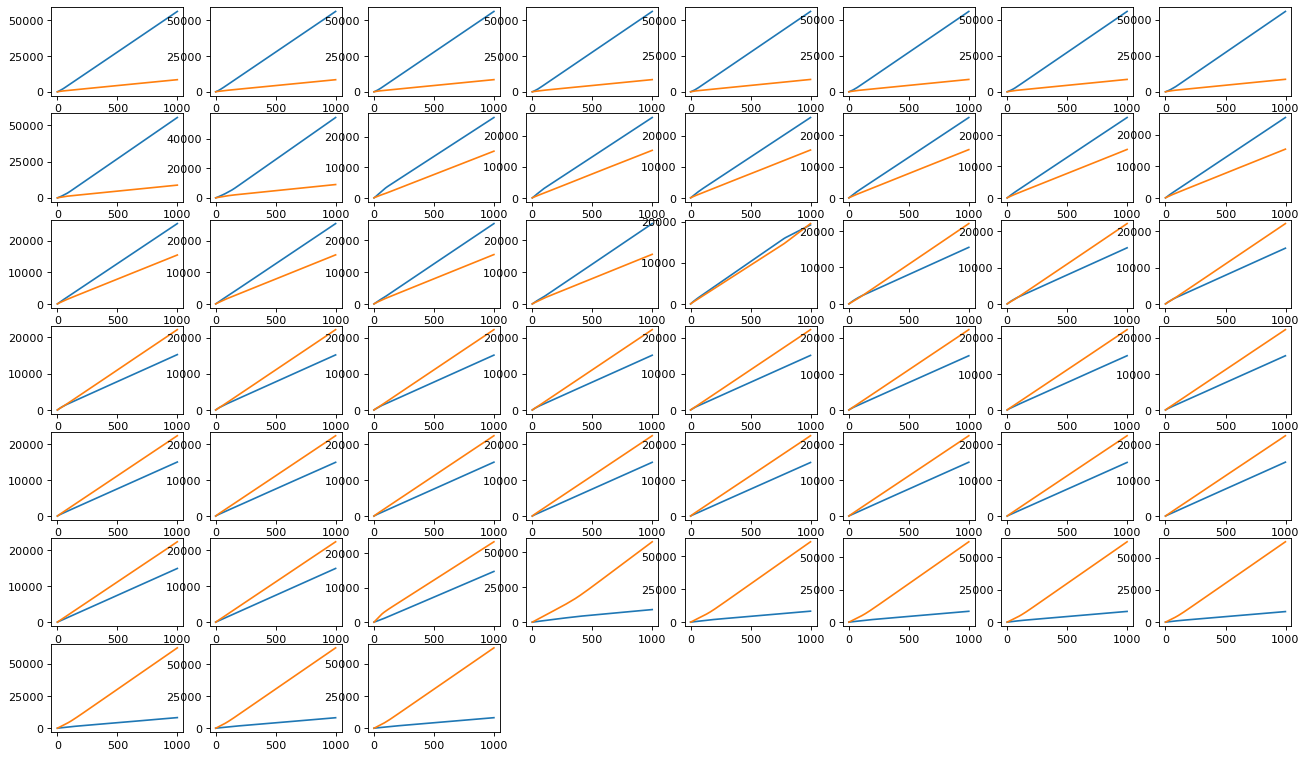

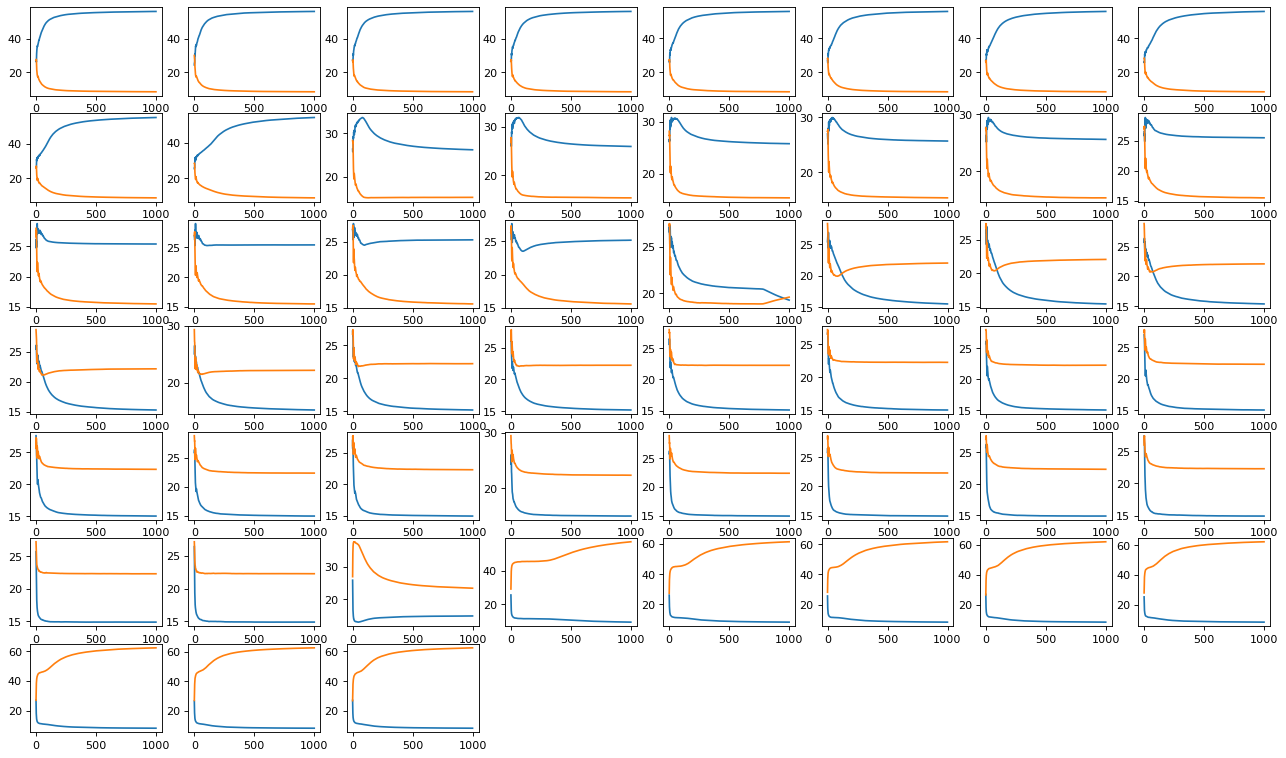

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


x = np.arange(T)
figure(figsize=(20,12), dpi=80)
cum_rew_regret = np.zeros((T,W))
cum_thr_regret = np.zeros((T,W))
for w in range(W):
    cum_rew_regret[:,w] = np.cumsum(np.mean(reward_regret[:,:,w], 0))
    cum_thr_regret[:,w] = np.cumsum(np.mean(threat_regret[:,:,w], 0))
    plt.subplot(7,8,w+1)
    plt.plot(x, cum_rew_regret[:,w], x, cum_thr_regret[:,w])
    #plt.legend(['reward regret', 'threat regret'])
    #print(cum_rew_regret)
# now plot time-averaged regrets

for t in range(T):
    cum_rew_regret[t,:]/=(t+1)
    cum_thr_regret[t,:]/=(t+1)

figure(figsize=(20,12), dpi=80)
plt.figure(2)
for w in range(W):
    plt.subplot(7,8,w+1)
    plt.plot(x, cum_rew_regret[:,w], x, cum_thr_regret[:,w] )

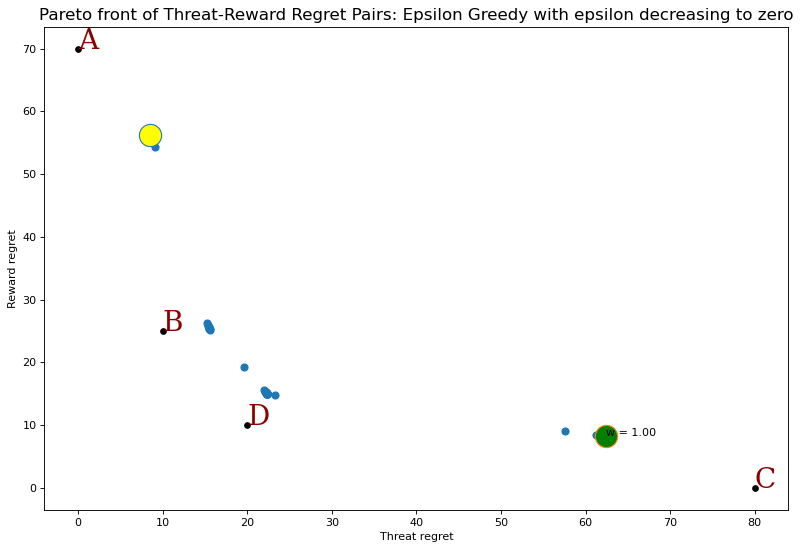

In [8]:
# plotting asymptotics against the weight.
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
np.shape(reward_regret)
y = cum_rew_regret[T-1,:] # make T larger average over last few time steps
x = cum_thr_regret[T-1,:]
# print(x)
# print(y)
annotations=[]

for w in range(W):
    f = format(w*p, ".2f")
    annotations = np.append(annotations,"w = "+str(f) )
plt.scatter(x,y, s=40)
plt.xlabel("Threat regret")
plt.ylabel("Reward regret")
plt.title("Pareto front of Threat-Reward Regret Pairs: Epsilon Greedy with epsilon decreasing to zero",fontsize=15)
# for i, label in enumerate(annotations):
#     plt.annotate(label, (x[i], y[i]))
# print(annotations)

# plt.text(50,50, 'pos reward = ' + str(pos_reward), style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},fontsize=20)
# plt.text(50,60, 'neg reward = ' + str(neg_reward), style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},fontsize=20)


# Pareto front plotter
# returns true only if (a,b) is not Pareto dominated by (a1,b1)
def isPareto(a,b,a1,b1):
    if a1 > a:
        return True
    elif b1 > b:
        return True
    else:
        return False
#print(isPareto(0.2,0.2,0.2,0.2))

n = np.size(x)
# for i in range(n):
#     count = 0
#     for j in range(n):
#         if  isPareto(x[i], y[i], x[j], y[j]):
#             count+=1
#     #print(x[i], y[i])
#     #print(count)
#     if count==n-1:
# #         print(x[i],y[i])
#         plt.plot(x[i], y[i],marker="o",markersize=10, markeredgecolor="red",
#             markerfacecolor="orange")
# #         plt.annotate(x[i], y[i])
plt.plot(x[0], y[0], marker = "o", markersize = 20, markerfacecolor = "yellow")
plt.plot(x[n-1], y[n-1], marker = "o", markersize = 20, markerfacecolor = "green")

plt.annotate(annotations[n-1], (x[n-1], y[n-1]))    
plt.plot(thr_regret,regret, "kx", marker = "o", markersize = 5, markerfacecolor = "black")
thr_regret = np.round(thr_regret, 2)
regret = np.round(regret, 2)
lbls = ['A ', 'B', 'C', 'D']
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 25,
        }
for i in range(4):
    plt.text(thr_regret[i], regret[i], lbls[i], fontdict = font )
plt.show()

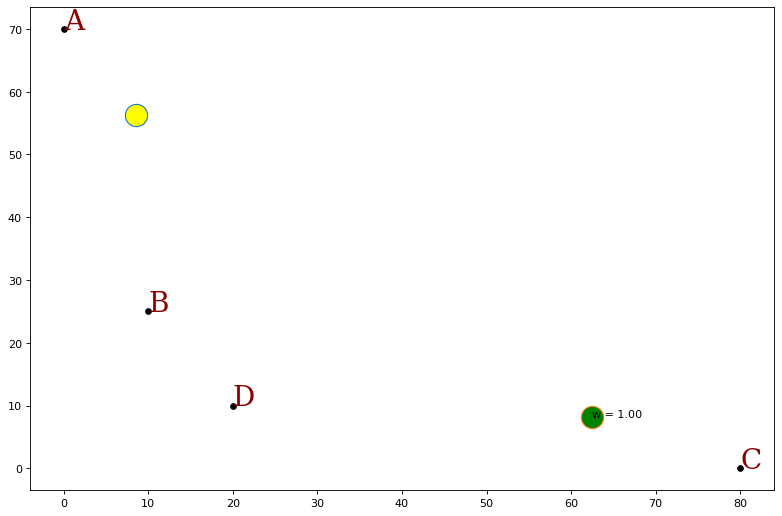

In [6]:
# plotting average over last few time-steps, not the whole horizon.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)


K = 100
tail_rewards = np.mean(rewards[:,T-K:-1,:],0)
tail_threats = np.mean(threats[:,T-K:-1,:],0)

yy = max_reward_mean - np.mean(tail_rewards,0)
xx = max_threat_mean - np.mean(tail_threats,0)

plt.plot(x[0], y[0], marker = "o", markersize = 20, markerfacecolor = "yellow")
plt.plot(x[n-1], y[n-1], marker = "o", markersize = 20, markerfacecolor = "green")

plt.annotate(annotations[n-1], (x[n-1], y[n-1]))    
plt.plot(thr_regret,regret, "kx", marker = "o", markersize = 5, markerfacecolor = "black")
thr_regret = np.round(thr_regret, 2)
regret = np.round(regret, 2)
lbls = ['A ', 'B', 'C', 'D']
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 25,
        }
for i in range(4):
    plt.text(thr_regret[i], regret[i], lbls[i], fontdict = font )
plt.show()

In [7]:
# Pareto front plotter
# Decides if (a,b) Pareto Dominates (a1,b1)
def isPareto(a,b,a1,b1):
    if a>a1:
        return False
    elif b>b1:
        return False
    else:
        return True
